In [406]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D, Flatten, SimpleRNN, GRU, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
import os

# Aula 20: Geração de Conteúdo
**Objetivo: ao fim desta aula, o aluno será capaz de usar redes neurais para gerar conteúdo**

In [407]:
import urllib
url = "https://www.gutenberg.org/cache/epub/3333/pg3333.txt" # Os Lusíadas (Camões)
url = "https://www.gutenberg.org/files/11/11-0.txt" #Alice in Wonderland
texto = urllib.request.urlopen(url).read().decode()[3000:-20000]
texto = texto.replace("\r\n", " ")
texto = texto.replace("“", "")
texto = texto.replace("”", "")
texto = texto.lower()
#print(texto[-1000:-1])


! she exclaimed in a tone of great dismay, and began picking them up again as quickly as she could, for the accident of the goldfish kept running in her head, and she had a vague sort of idea that they must be collected at once and put back into the jury-box, or they would die.  the trial cannot proceed, said the king in a very grave voice, until all the jurymen are back in their proper places—_all_, he repeated with great emphasis, looking hard at alice as he said so.  alice looked at the jury-box, and saw that, in her haste, she had put the lizard in head downwards, and the poor little thing was waving its tail about in a melancholy way, being quite unable to move. she soon got it out again, and put it right; not that it signifies much, she said to herself; i should think it would be _quite_ as much use in the trial one way up as the other.  as soon as the jury had a little recovered from the shock of being upset, and their slates and pencils had been found and handed back to them, t

# Exercício 1
*Objetivo: lembrar-se de como funcionam os modelos de geração de conteúdo por n-gramas*

Analise os códigos abaixo, relacionados aos modelos clássicos de geração de conteúdo por n-gramas.

1. Em linhas gerais, como eles funcionam?
1. O que é levado em consideração (ou: o que é a "entrada") para cada geração de uma nova palavra?

In [408]:
import re
frases = re.split('[.]', texto)[4:]
tokens = [ re.findall("\w+", f) for f in frases ]
tokens = [ [w.lower() for w in f] for f in tokens]
print(tokens[0:2])


[['well', 'thought', 'alice', 'to', 'herself', 'after', 'such', 'a', 'fall', 'as', 'this', 'i', 'shall', 'think', 'nothing', 'of', 'tumbling', 'down', 'stairs', 'how', 'brave', 'they', 'll', 'all', 'think', 'me', 'at', 'home', 'why', 'i', 'wouldn', 't', 'say', 'anything', 'about', 'it', 'even', 'if', 'i', 'fell', 'off', 'the', 'top', 'of', 'the', 'house', 'which', 'was', 'very', 'likely', 'true'], ['down', 'down', 'down']]


In [409]:
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
n = 5
train_data, vocab = padded_everygram_pipeline(n, tokens)
lm = MLE(n)
lm.fit(train_data, vocab)
texto_ = lm.generate(100, random_seed=90)
texto_ = " ".join(texto_)
print(texto_)

<s> <s> <s> but she must have a prize herself you know said the mouse </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s> </s>


# Exercício 2
*Objetivo: relacionar um modelo de geração por n-gramas a um modelo de geração com rede feed-forward*

Analise a rede neural abaixo.

1. Quais são as suas entradas?
1. Quais são suas saídas?
1. Como essa ideia se relaciona ao modelo de geração por modelo linguístico do exercício 1?

In [410]:
from keras.preprocessing.text import Tokenizer
vocab_size = 2000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(frases)
sequences = tokenizer.texts_to_sequences(frases)

In [411]:
# Construindo n-gramas!
n = 10
x = []
y = []
frases_teste = 800
for f in range(frases_teste):
    frase_atual = sequences[f]
    for n_ in range(len(frase_atual)-n-1):
        x_ = frase_atual[n_:n_+n]
        y_ = [frase_atual[n_+n]]
        x.append(x_)
        y.append(y_)
print(x[0], x[1])
print(y[0], y[1])

[75, 56, 10, 3, 49, 109, 110, 4, 463, 15] [56, 10, 3, 49, 109, 110, 4, 463, 15, 28]
[28] [9]


In [412]:
# Passando minhas saidas para one-hot encoding
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y).toarray()
print(vocab_size, y_ohe.shape)

2000 (13556, 1738)


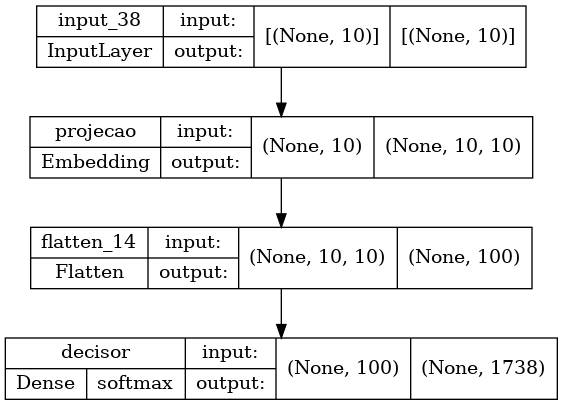

In [413]:
def rede_neural_predizer_palavras(input_dims, vocab_size, dim_latente, dim_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(vocab_size, dim_latente, name='projecao')(x)
  x = Flatten()(x)
  y = Dense(dim_out, activation='softmax', name='decisor')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_predizer_palavras(n, vocab_size, 10, y_ohe.shape[1])
rede_neural.compile(optimizer='adam', loss='categorical_crossentropy')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [414]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(np.array(x), y_ohe, epochs=30)#, validation_split=0.2, callbacks=es)

Epoch 1/30
424/424 [==============================] - 3s 5ms/step - loss: 6.5884
Epoch 2/30
424/424 [==============================] - 2s 4ms/step - loss: 5.8840
Epoch 3/30
424/424 [==============================] - 2s 6ms/step - loss: 5.7817
Epoch 4/30
424/424 [==============================] - 2s 5ms/step - loss: 5.6292
Epoch 5/30
424/424 [==============================] - 2s 5ms/step - loss: 5.3851
Epoch 6/30
424/424 [==============================] - 2s 5ms/step - loss: 5.0563
Epoch 7/30
424/424 [==============================] - 2s 6ms/step - loss: 4.6763
Epoch 8/30
424/424 [==============================] - 2s 5ms/step - loss: 4.2853
Epoch 9/30
424/424 [==============================] - 1s 3ms/step - loss: 3.9120
Epoch 10/30
424/424 [==============================] - 1s 3ms/step - loss: 3.5761
Epoch 11/30
424/424 [==============================] - 1s 3ms/step - loss: 3.2900
Epoch 12/30
424/424 [==============================] - 2s 5ms/step - loss: 3.0568
Epoch 13/30
424/424 [====

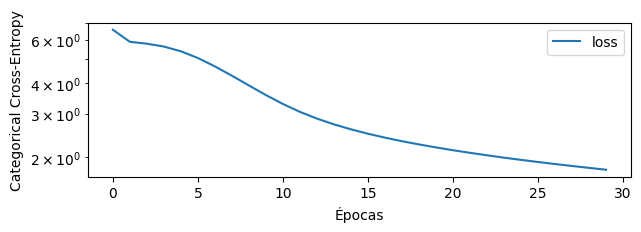

In [415]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.semilogy()
plt.ylabel('Categorical Cross-Entropy')
plt.legend()
plt.show()

In [416]:
print(np.array([x[0]]))
y0 = rede_neural.predict(np.array([x[0]]))

[[ 75  56  10   3  49 109 110   4 463  15]]


In [417]:
# Prever sequencia a partir de um inicio
n_palavras = 100
seq = list(x[30])
print(tokenizer.sequences_to_texts([seq]), end='')
y_ = []
for palavra in range(n_palavras):
    y0 = rede_neural.predict(np.array([seq]))
    y0[0,0] = 0 # Proibido usar "\r" na saida
    y0_seq = ohe.inverse_transform(y0)
    #print(y0_seq)
    #print(tokenizer.sequences_to_texts(y0_seq))
    y_.append(y0_seq[0])
    print(tokenizer.sequences_to_texts([y0_seq[0]]), end='')
    seq.append(y0_seq[0][0])
    seq = seq[1:]
    #print(seq)
    
print(" ---- ")
words = tokenizer.sequences_to_texts(y_)
print(words)
texto_ = ' '.join(words)
print(texto_)


['say anything about it even if i fell off the']['top']['of']['his']['there']['you']['are']['not']['too']['it']['is']['to']['be']['a']['little']['thing']['had']['no']['speak']['to']['me']['but']['she']['did']['either']['like']['a']['long']['thing']['to']['be']['a']['thing']['to']['be']['and']['said']['to']['herself']['and']['she']['had']['to']['see']['that']['it']['was']['only']['of']['it']['and']['she']['was']['a']['like']['it']['had']['to']['her']['that']['she']['was']['a']['took']['it']['and']['she']['was']['that']['she']['was']['out']['under']['her']['as']['she']['was']['a']['like']['it']['had']['to']['leave']['that']['she']['made']['about']['took']['it']['was']['a']['like']['that']['she']['was']['not']['very']['to']['be']['in']['a'] ---- 
['top', 'of', 'his', 'there', 'you', 'are', 'not', 'too', 'it', 'is', 'to', 'be', 'a', 'little', 'thing', 'had', 'no', 'speak', 'to', 'me', 'but', 'she', 'did', 'either', 'like', 'a', 'long', 'thing', 'to', 'be', 'a', 'thing', 'to', 'be', 'and', 

In [418]:
texto_ = ' '.join(words)
print(texto_)

top of his there you are not too it is to be a little thing had no speak to me but she did either like a long thing to be a thing to be and said to herself and she had to see that it was only of it and she was a like it had to her that she was a took it and she was that she was out under her as she was a like it had to leave that she made about took it was a like that she was not very to be in a


# Exercício 3
*Objetivo: discutir o espaço latente gerado pela rede neural*

Visualizando o espaço latente da rede neural, você consegue verificar alguma relação entre as posições de palavras importantes do texto e seus significados?

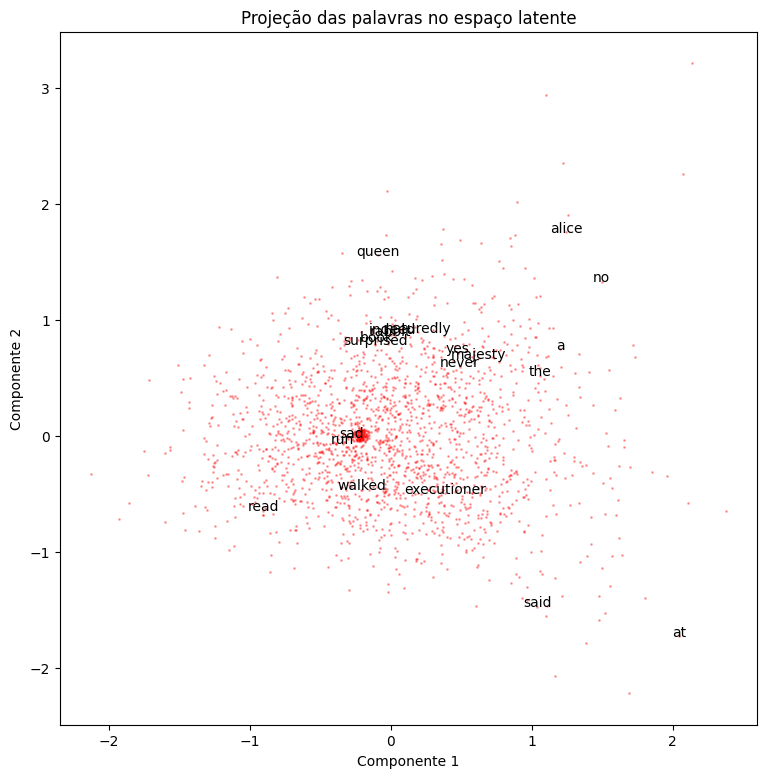

In [419]:
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

proj = PCA(n_components=2)
v = proj.fit_transform(v_)
#v = v_

plt.figure(figsize=(9,9))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='r')
for s in ["alice", "rabbit", "queen", "majesty", "surprised", "never", "executioner", "run", "read", "book", "walked", "said", "sad", "a", "at", "the", "yes", "no", "indeed", "naturedly"]:
    #print(s)
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-0.20,0.20])
#plt.ylim([-0.20,0.20])
plt.show()

## Análise do espaço latente

In [420]:
palavras = tokenizer.word_index.keys()
print(len(palavras))

2772


### Raio das palavras no espaço latente

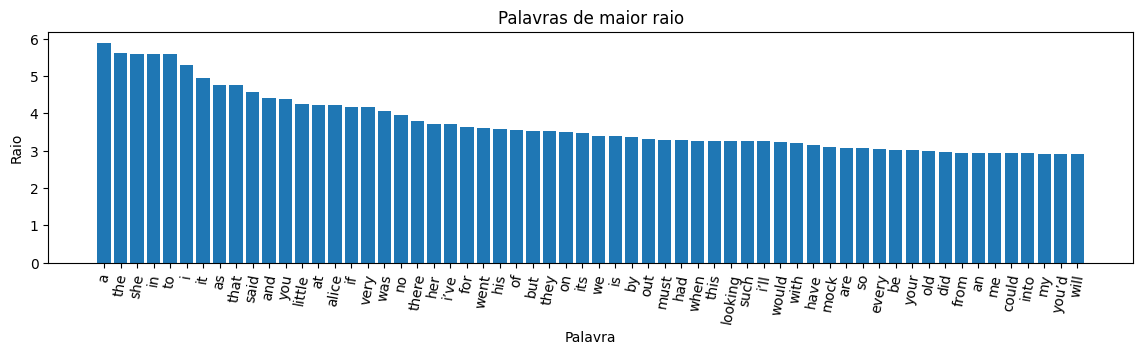

In [421]:
raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum(v_[idx,:]**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Palavras de maior raio')
plt.show()

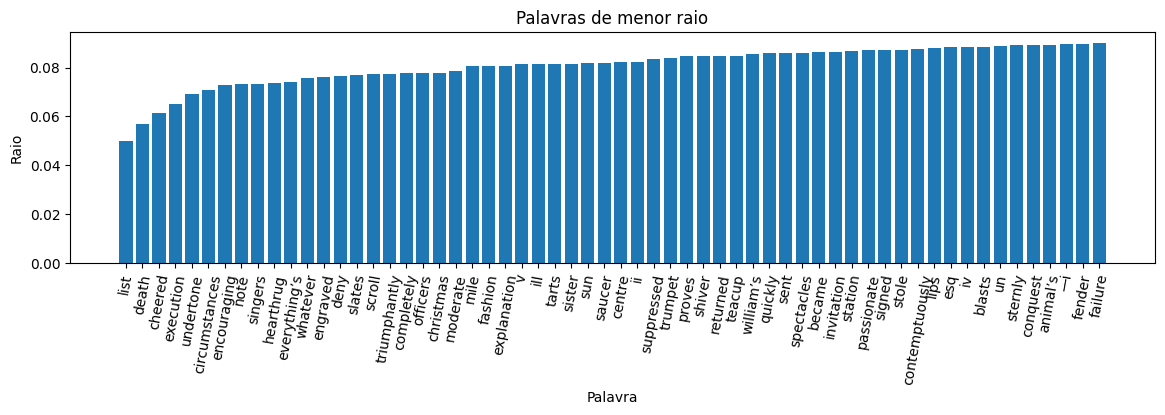

In [422]:
raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum(v_[idx,:]**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Palavras de menor raio')
plt.show()

### Palavras mais próximas de "Alice"

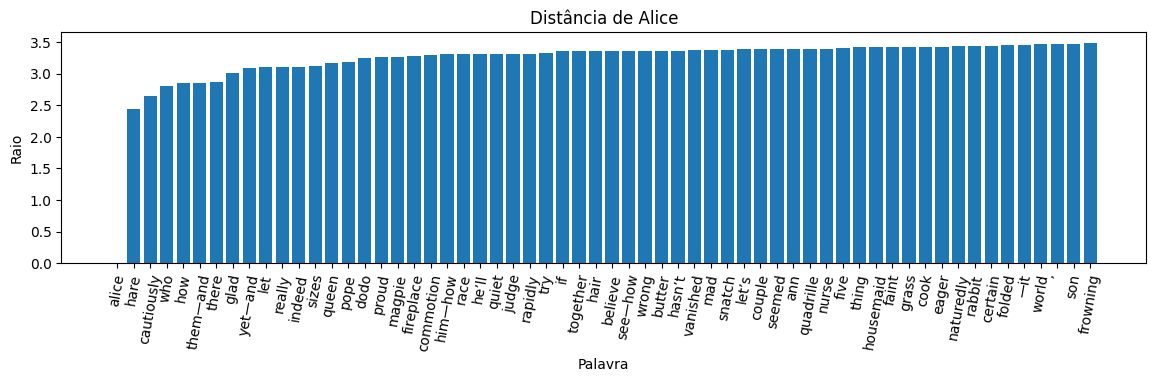

In [423]:
alice_idx = tokenizer.word_index['alice']

raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum( (v_[idx,:]-v_[alice_idx,:])**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Distância de Alice')
plt.show()

# Modelo: rede neural recorrente

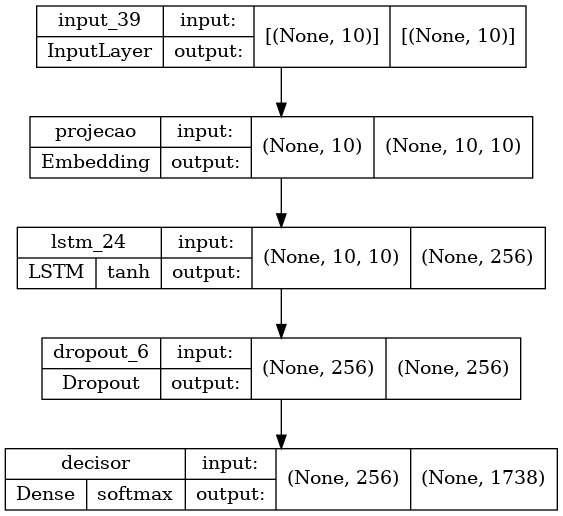

In [424]:
def rede_neural_predizer_palavras(input_dims, vocab_size, dim_latente, dim_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(vocab_size, dim_latente, name='projecao')(x)
  # x = LSTM(256, return_sequences=True)(x)
  # x = Dropout(0.2)(x)
  x = LSTM(256)(x)
  x = Dropout(0.2)(x)
  y = Dense(dim_out, activation='softmax', name='decisor')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_predizer_palavras(n, vocab_size, 10, y_ohe.shape[1])
rede_neural.compile(optimizer='adam', loss='categorical_crossentropy')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [425]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(np.array(x), y_ohe, epochs=60)#, validation_split=0.2, callbacks=es)

Epoch 1/60
424/424 [==============================] - 5s 9ms/step - loss: 6.1478
Epoch 2/60
424/424 [==============================] - 4s 9ms/step - loss: 5.8260
Epoch 3/60
424/424 [==============================] - 4s 9ms/step - loss: 5.6902
Epoch 4/60
424/424 [==============================] - 2s 6ms/step - loss: 5.5428
Epoch 5/60
424/424 [==============================] - 2s 6ms/step - loss: 5.4107
Epoch 6/60
424/424 [==============================] - 3s 6ms/step - loss: 5.2788
Epoch 7/60
424/424 [==============================] - 2s 5ms/step - loss: 5.1411
Epoch 8/60
424/424 [==============================] - 2s 6ms/step - loss: 4.9837
Epoch 9/60
424/424 [==============================] - 2s 6ms/step - loss: 4.8110
Epoch 10/60
424/424 [==============================] - 2s 6ms/step - loss: 4.6277
Epoch 11/60
424/424 [==============================] - 2s 6ms/step - loss: 4.4270
Epoch 12/60
424/424 [==============================] - 2s 6ms/step - loss: 4.2052
Epoch 13/60
424/424 [====

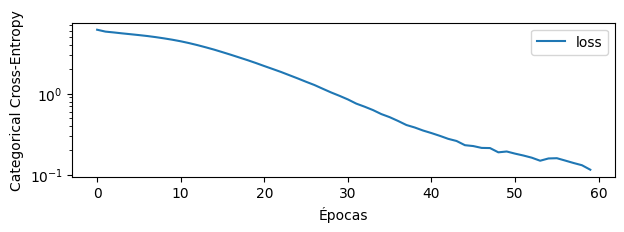

In [426]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.semilogy()
plt.ylabel('Categorical Cross-Entropy')
plt.legend()
plt.show()

In [427]:
# Prever sequencia a partir de um inicio
n_palavras = 100
seq = list(x[30])
print(tokenizer.sequences_to_texts([seq]), end='')
y_ = []
for palavra in range(n_palavras):
    y0 = rede_neural.predict(np.array([seq]))
    y0[0,0] = 0 # Proibido usar "\r" na saida
    y0_seq = ohe.inverse_transform(y0)
    #print(y0_seq)
    #print(tokenizer.sequences_to_texts(y0_seq))
    y_.append(y0_seq[0])
    print(tokenizer.sequences_to_texts([y0_seq[0]]), end='')
    seq.append(y0_seq[0][0])
    seq = seq[1:]
    #print(seq)
    
print(" ---- ")
words = tokenizer.sequences_to_texts(y_)
print(words)
texto_ = ' '.join(words)
print(texto_)

['say anything about it even if i fell off the']['top']['of']['your']['house']['you']['was']['back']['out']['in']['a']['minute']['tone']['at']['its']['time']['and']['she']['set']['to']['work']['at']['half']['herself']['what']['was']['is']['with']['a']['minute']['or']['two']['sobs']['choked']['and']['as']['to']['a']['great']['deal']['with']['draggled']['is']['you']['are']['quite']['hear']['you']['little']['never']['and']['were']['you']['old']['join']['to']['do']['what']['i']['know']['down']['i']['should']['be']['least']['i']['heads']['any']['how']['finish']['they']['did']['don’t']['taught']['you']['dear']['bats']['very']['history']['said']['i']['is']['i']['should']['got']['to']['do']['you']['no']['make']['she']['came']['said']['this']['as']['it']['hastily']['not']['time']['to']['go'] ---- 
['top', 'of', 'your', 'house', 'you', 'was', 'back', 'out', 'in', 'a', 'minute', 'tone', 'at', 'its', 'time', 'and', 'she', 'set', 'to', 'work', 'at', 'half', 'herself', 'what', 'was', 'is', 'with', '

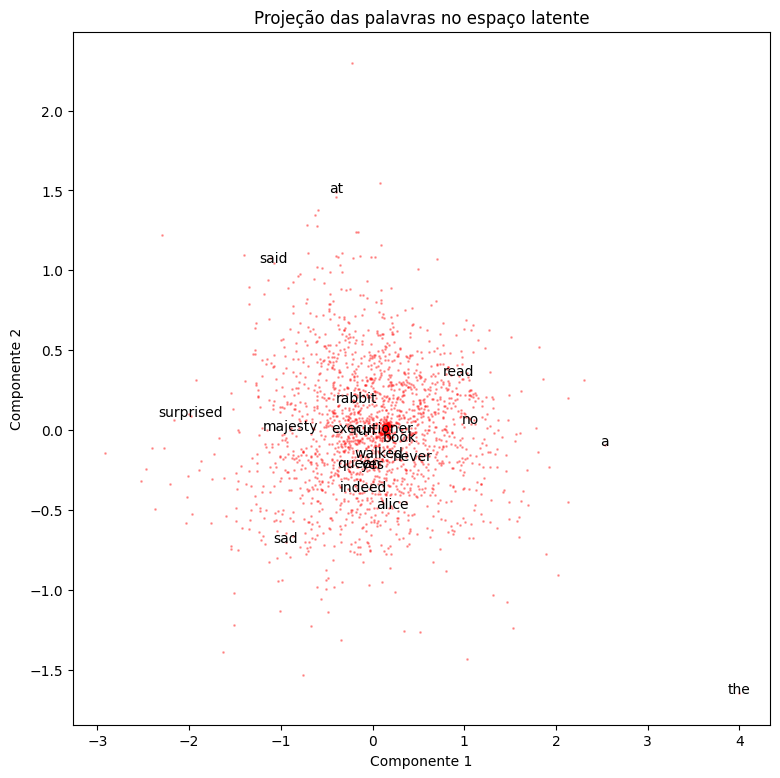

In [428]:
# Visualização: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

proj = PCA(n_components=2)
v = proj.fit_transform(v_)
#v = v_

plt.figure(figsize=(9,9))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='r')
for s in ["alice", "rabbit", "queen", "majesty", "surprised", "never", "executioner", "run", "read", "book", "walked", "said", "sad", "a", "at", "the", "yes", "no", "indeed"]:
    #print(s)
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-0.20,0.20])
#plt.ylim([-0.20,0.20])
plt.show()

## Análise do espaço latente

In [429]:
palavras = tokenizer.word_index.keys()
print(len(palavras))

2772


### Raio das palavras no espaço latente

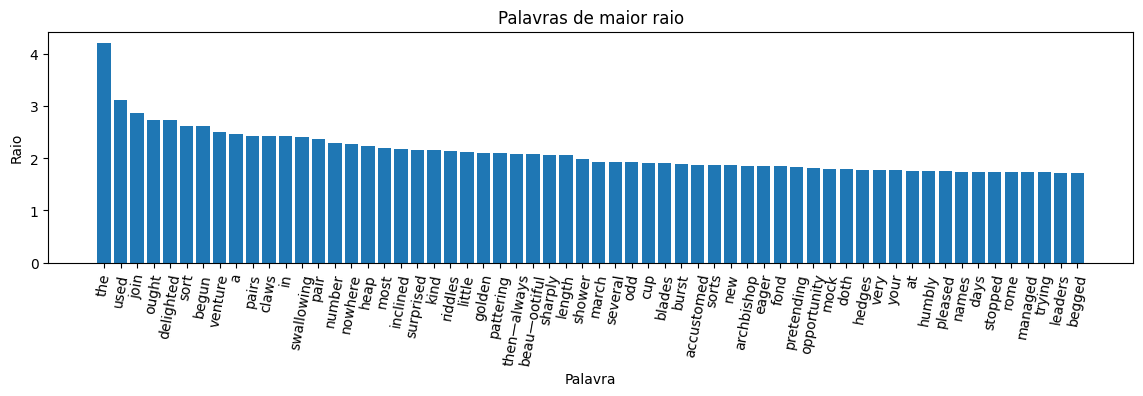

In [430]:
raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum(v_[idx,:]**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Palavras de maior raio')
plt.show()

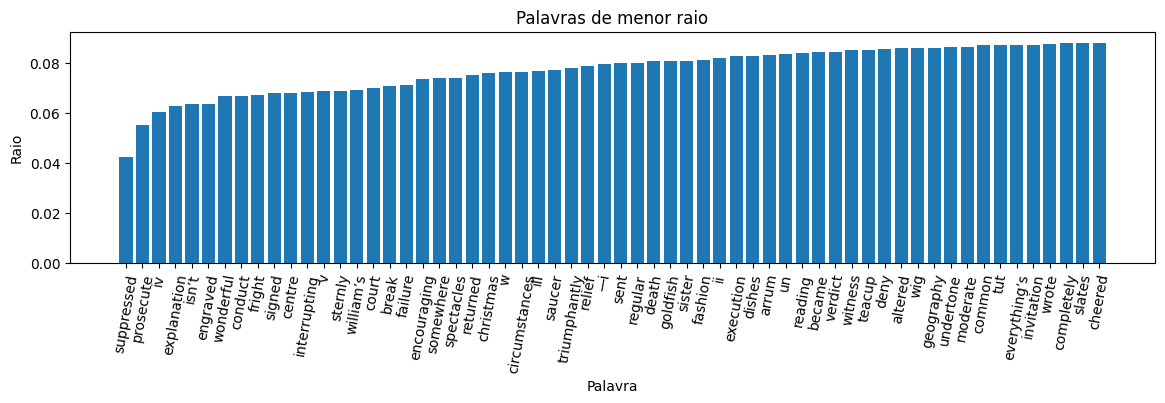

In [431]:
raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum(v_[idx,:]**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Palavras de menor raio')
plt.show()

### Palavras mais próximas de "Alice"

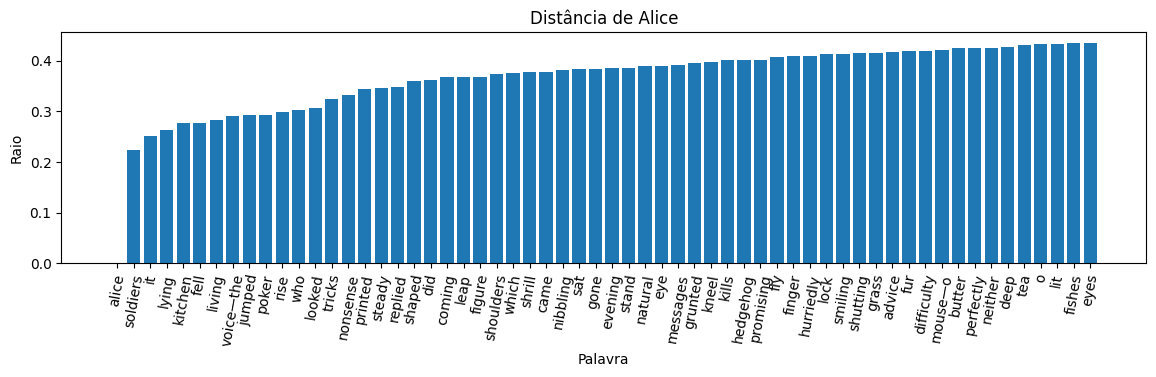

In [432]:
alice_idx = tokenizer.word_index['alice']

raios = []
for idx in range(1,2000):
    w = tokenizer.index_word[idx]
    r = np.sqrt(np.sum( (v_[idx,:]-v_[alice_idx,:])**2))
    raios.append ( (r, w) )

tuplas_ordenadas = sorted(raios) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]
eixo_x = np.arange(len(palavras))
n_palavras = 60
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=80)
plt.ylabel('Raio')
plt.xlabel('Palavra')
plt.title('Distância de Alice')
plt.show()